In [65]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import plotly.express as px
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import shap

c:\informatique\cancer\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [19]:
cervical_cancer_risk_factors = fetch_ucirepo(id=383)
data=cervical_cancer_risk_factors.data.features

In [20]:
df=data.copy()
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [21]:
df.shape

(858, 36)

In [22]:
df.dtypes.value_counts()

float64    26
int64      10
Name: count, dtype: int64

In [23]:
fig = px.pie(
    names=df.dtypes.value_counts().index.astype(str),  
    values=df.dtypes.value_counts().values,  
    title="Répartition des types de données dans le DataFrame"
)
fig.show()

In [24]:
#Calcul su ratio des données manquantes par colones 
(df.isna().sum().sort_values(ascending=False))/(df.shape[0])

STDs: Time since last diagnosis       0.917249
STDs: Time since first diagnosis      0.917249
IUD                                   0.136364
IUD (years)                           0.136364
Hormonal Contraceptives               0.125874
Hormonal Contraceptives (years)       0.125874
STDs:pelvic inflammatory disease      0.122378
STDs:vulvo-perineal condylomatosis    0.122378
STDs:HPV                              0.122378
STDs:Hepatitis B                      0.122378
STDs:HIV                              0.122378
STDs:AIDS                             0.122378
STDs:molluscum contagiosum            0.122378
STDs:genital herpes                   0.122378
STDs:syphilis                         0.122378
STDs:vaginal condylomatosis           0.122378
STDs:cervical condylomatosis          0.122378
STDs:condylomatosis                   0.122378
STDs (number)                         0.122378
STDs                                  0.122378
Num of pregnancies                    0.065268
Number of sex

In [25]:
#suppresion des colone STDs: Time since first diagnosis et STDs: Time since last diagnosis  
df=df.drop(['STDs: Time since last diagnosis','STDs: Time since first diagnosis'],axis=1)

In [26]:
#Travaux sur les variables binaire 
tableaux_col_binaire = []

for col in df.columns:
    if df[col].nunique() <= 2:  
        tableaux_col_binaire.append(col)
        
print(tableaux_col_binaire)

['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']


In [27]:
#on peut constater apres traçage que beaucoup de variable ne sont pas necessaire ,on va tout supprimer sauf La biopsy
num_cols = len(tableaux_col_binaire)

cols_per_row = 2

num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

fig = sp.make_subplots(rows=num_rows, cols=cols_per_row, 
                       subplot_titles=tableaux_col_binaire,
                       specs=[[{"type": "domain"}, {"type": "domain"}] for _ in range(num_rows)])

for i, col in enumerate(tableaux_col_binaire):
    row = i // cols_per_row + 1
    col_pos = i % cols_per_row + 1
    
    counts = df[col].value_counts()
    
    fig.add_trace(go.Pie(labels=counts.index.astype(str), values=counts.values, name=col),
                  row=row, col=col_pos)
fig.update_layout(title_text="Répartition des colonnes binaires", showlegend=True, height=300 * num_rows)

fig.show()


In [28]:
tableaux_col_binaire.pop(-1)
df=df.drop(tableaux_col_binaire,axis=1)

In [29]:
#nouvelle taille de la data
df.shape

(858, 11)

In [30]:
#visualisation des valeur manquantes 
px.imshow(df.isnull(),title='heatmap des valeurs manquantes')
#on constate à travers cette heatmpa la distribution des valeur manquantes 

In [31]:
df.shape

(858, 11)

In [32]:
#Tracer des boxplot pour chaque colone . On constate la présence d'outliers 
colonnes_a_tracer = df.select_dtypes(include=['number']).columns[:11]

num_cols = len(colonnes_a_tracer)

cols_per_row = 2  

num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)
fig = sp.make_subplots(
    rows=num_rows, cols=cols_per_row,
    subplot_titles=colonnes_a_tracer,
    specs=[[{"type": "box"}, {"type": "box"}] for _ in range(num_rows)]
)

for i, col in enumerate(colonnes_a_tracer):
    row = i // cols_per_row + 1
    col_pos = i % cols_per_row + 1
    
    fig.add_trace(go.Box(y=df[col], name=col), row=row, col=col_pos)
fig.update_layout(
    title_text="Boxplots des 11 colonnes sélectionnées",
    height=300 * num_rows,
    showlegend=False
)

fig.show()

In [37]:
#remplissage de la data par les mediane 
for col in df.columns:
    df[col]=df[col].fillna(df[col].median())

In [38]:
fig=px.imshow(df.isnull(),title='heatmap de données manquantes')
fig.show()

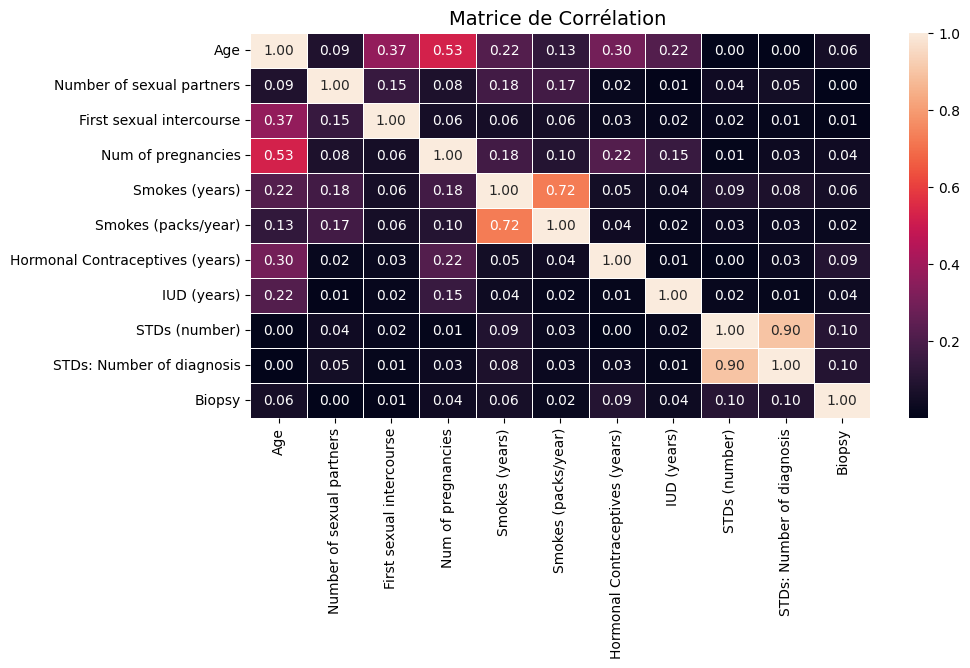

In [59]:
#Matrice de corrélation : on peut remarquer il n'ya que quelqes variables qui sont corrélées
df_corr = df.corr().abs()
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr ,  
            annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation ", fontsize=14)
plt.show()

In [ ]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_classification_model_plotly(model, X_train, X_test, y_train, y_test):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"): 
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_train_prob = y_train_pred  
        y_test_prob = y_test_pred

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    annotations_train = [[str(cm_train[i][j]) for j in range(len(cm_train))] for i in range(len(cm_train))]
    annotations_test = [[str(cm_test[i][j]) for j in range(len(cm_test))] for i in range(len(cm_test))]

    fig_cm = make_subplots(rows=1, cols=2, subplot_titles=["Matrice de confusion - Entraînement", "Matrice de confusion - Test"])
    
    fig_cm.add_trace(go.Heatmap(z=cm_train, x=["Prédit 0", "Prédit 1"], y=["Réel 0", "Réel 1"], 
                                colorscale="Blues", showscale=True, text=annotations_train, texttemplate="%{text}"), row=1, col=1)
    fig_cm.add_trace(go.Heatmap(z=cm_test, x=["Prédit 0", "Prédit 1"], y=["Réel 0", "Réel 1"], 
                                colorscale="Reds", showscale=True, text=annotations_test, texttemplate="%{text}"), row=1, col=2)
    
    fig_cm.update_layout(title_text="Matrices de Confusion", height=400, width=800)
    fig_cm.show()

    # Courbes ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    fig_roc = go.Figure()

    fig_roc.add_trace(go.Scatter(x=fpr_train, y=tpr_train, mode="lines", name=f"ROC Train (AUC = {roc_auc_train:.2f})", line=dict(color="blue")))
    fig_roc.add_trace(go.Scatter(x=fpr_test, y=tpr_test, mode="lines", name=f"ROC Test (AUC = {roc_auc_test:.2f})", line=dict(color="red")))
    fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Ligne de référence", line=dict(color="gray", dash="dash")))

    fig_roc.update_layout(title="Courbe ROC", xaxis_title="Taux de faux positifs (FPR)", yaxis_title="Taux de vrais positifs (TPR)", height=500, width=600)
    fig_roc.show()

    # Affichage des métriques de classification
    print("Classification Report - Entraînement:\n", classification_report(y_train, y_train_pred))
    print("Classification Report - Test:\n", classification_report(y_test, y_test_pred))

# Utilisation :
# evaluate_classification_model_plotly(mon_modele, X_train, X_test, y_train, y_test)


In [46]:
#verification du désiquilibre ou non de la  colone BiopSy
fig = px.pie(df, names='Biopsy', title="Répartition de la classe cible (Biopsy)")
fig.show()

In [53]:
#subdivisions de la data en partie train et test
from sklearn.model_selection import train_test_split
X=df.drop('Biopsy',axis=1)
y=df['Biopsy']
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=47,stratify=y,shuffle=True)

In [54]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3, random_state=42)
x_train,y_train=smote.fit_resample(X, y)

In [55]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
scale.fit(x_train)
x_train=scale.transform(x_train)
x_test=scale.transform(x_test)

In [58]:
#randomforest 
from sklearn.ensemble import RandomForestClassifier

model_RandomForestClassifier=RandomForestClassifier(random_state=42,n_estimators=150,criterion='entropy',max_depth=20)
model_RandomForestClassifier.fit(x_train,y_train)
evaluate_classification_model_plotly(model_RandomForestClassifier,x_train,x_test,y_train,y_test)


Classification Report - Entraînement:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1606
   macro avg       1.00      1.00      1.00      1606
weighted avg       1.00      1.00      1.00      1606

Classification Report - Test:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      0.93      0.96        14

    accuracy                           1.00       215
   macro avg       1.00      0.96      0.98       215
weighted avg       1.00      1.00      1.00       215



In [60]:
from xgboost import XGBClassifier

model_XGBClassifier=XGBClassifier(n_estimateurs=100,max_depth=15,learning_rate=0.1,objective='binary:logistic')

model_XGBClassifier.fit(x_train,y_train)
evaluate_classification_model_plotly(model_XGBClassifier,x_train,x_test,y_train,y_test)

c:\informatique\cancer\env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimateurs" } are not used.




Classification Report - Entraînement:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1606
   macro avg       1.00      1.00      1.00      1606
weighted avg       1.00      1.00      1.00      1606

Classification Report - Test:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       201
           1       1.00      0.86      0.92        14

    accuracy                           0.99       215
   macro avg       1.00      0.93      0.96       215
weighted avg       0.99      0.99      0.99       215



In [61]:
from catboost import CatBoostClassifier
model_CatBoostClassifier= CatBoostClassifier(iterations=500,learning_rate=0.1,loss_function='Logloss',custom_metric='F1')
model_CatBoostClassifier.fit(x_train,y_train)
evaluate_classification_model_plotly(model_CatBoostClassifier,x_train,x_test,y_train,y_test)

0:	learn: 0.6371808	total: 10.1ms	remaining: 5.05s
1:	learn: 0.5960107	total: 16.6ms	remaining: 4.14s
2:	learn: 0.5519722	total: 21.8ms	remaining: 3.6s
3:	learn: 0.5195015	total: 26.5ms	remaining: 3.29s
4:	learn: 0.4975481	total: 72.8ms	remaining: 7.21s
5:	learn: 0.4707134	total: 80.2ms	remaining: 6.6s
6:	learn: 0.4383239	total: 86.6ms	remaining: 6.1s
7:	learn: 0.4247917	total: 91ms	remaining: 5.6s
8:	learn: 0.4075853	total: 94.5ms	remaining: 5.16s
9:	learn: 0.3947635	total: 100ms	remaining: 4.91s
10:	learn: 0.3825570	total: 105ms	remaining: 4.67s
11:	learn: 0.3648276	total: 108ms	remaining: 4.4s
12:	learn: 0.3489746	total: 111ms	remaining: 4.15s
13:	learn: 0.3418014	total: 117ms	remaining: 4.06s
14:	learn: 0.3269936	total: 120ms	remaining: 3.87s
15:	learn: 0.3175776	total: 123ms	remaining: 3.71s
16:	learn: 0.3108892	total: 125ms	remaining: 3.56s
17:	learn: 0.2998744	total: 128ms	remaining: 3.44s
18:	learn: 0.2913675	total: 134ms	remaining: 3.38s
19:	learn: 0.2859126	total: 137ms	remai

Classification Report - Entraînement:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1606
   macro avg       1.00      1.00      1.00      1606
weighted avg       1.00      1.00      1.00      1606

Classification Report - Test:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      0.93      0.96        14

    accuracy                           1.00       215
   macro avg       1.00      0.96      0.98       215
weighted avg       1.00      1.00      1.00       215



In [64]:
#On garde la Xg_boost comme meilleur modèle
feature_importance = model_CatBoostClassifier.get_feature_importance()
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
fig = px.bar(importance_df, x="Importance", y="Feature", title="Importance des Features (CatBoost)", orientation='h')
fig.show()


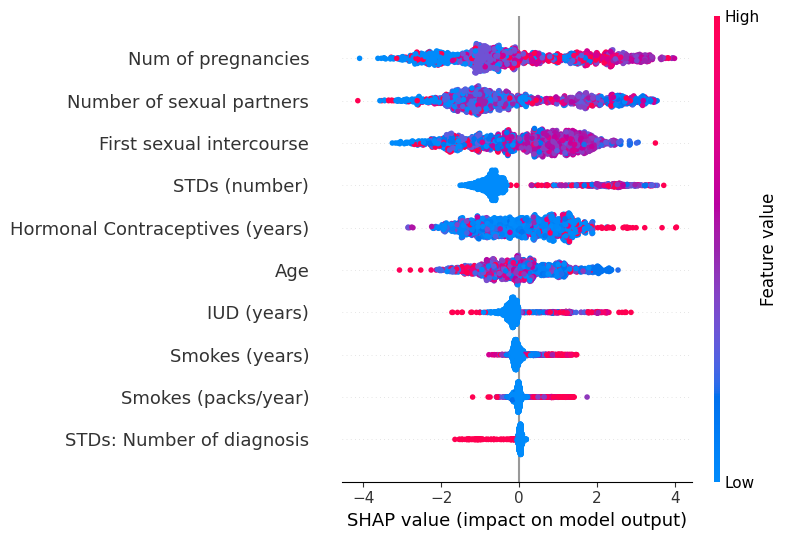

In [67]:
#utilisation de shap pour expliquer le model
explainer = shap.Explainer(model_CatBoostClassifier)
# Calcul des valeurs SHAP pour les données d'entraînement
x_train_with_columns=pd.DataFrame(x_train,columns=X.columns)
shap_values = explainer(x_train_with_columns)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, x_train_with_columns)

In [68]:
import joblib
joblib.dump(model_CatBoostClassifier,'catboost_model.pkl')

['catboost_model.pkl']

In [75]:
df.iloc[0:1,0:]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0


In [78]:
df[df['Biopsy']==1]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,Biopsy
6,51,3.0,17.0,6.0,34.000000,3.400000,0.00,7.0,0.0,0,1
22,40,1.0,18.0,1.0,0.000000,0.000000,0.25,0.0,2.0,1,1
23,40,1.0,20.0,2.0,0.000000,0.000000,15.00,0.0,0.0,0,1
41,37,2.0,18.0,2.0,0.000000,0.000000,0.00,0.0,1.0,1,1
44,37,3.0,19.0,3.0,12.000000,6.000000,13.00,0.0,0.0,0,1
64,38,2.0,15.0,4.0,0.000000,0.000000,16.00,0.0,0.0,0,1
93,33,1.0,29.0,2.0,0.000000,0.000000,0.50,0.0,0.0,0,1
96,35,5.0,11.0,2.0,15.000000,15.000000,14.00,0.0,0.0,0,1
103,38,3.0,18.0,4.0,0.000000,0.000000,10.00,2.0,0.0,0,1
131,30,2.0,13.0,3.0,22.000000,3.300000,0.00,0.0,1.0,1,1
